<a href="https://colab.research.google.com/github/Yizhao-Wang/ChatGPT-s-PPO/blob/main/Understanding_the_PPO_algorithm_behind_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [ ]:
#functions
def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))


# **Overview of ChatGPT**
Today we are surprised by the performance of ChatGPT in many areas. It can help people do a lot of work.


ChatGPT is an AI system that can engage in back-and-forth conversational interactions in a chatbot-style interface. It is capable of writing code, correcting or adjusting its responses based on the user's feedback.
ChatGPT is a complex system built on top of a large language model, such as GPT-3.5, and trained using both supervised learning and reinforcement learning methods.





In the following section we will first introduce the procedure of training ChatGPT, which includes the brief outline about the PPO method. Then we will give concrete explanation of the PPO algorithm and its predecessors - NPO and TRPO.

# **How to train ChatGPT**



The procedure of training mainly follows the article of [InstructGPT](https://arxiv.org/abs/2203.02155).
![picture](https://drive.google.com/uc?export=view&id=17lxcogettj8PwByqrmEqBgeQwA9ooyF8)


## **Step 0: Pre-train GPT-3.5**

GPT-3.5 is a large generative language model invented by openAI and trained by a self-supervised method (a self-supervised method is a kind of method whose training data can also be used as labels). There is no official article about it, but we assume that it's basically the extension of GPT-3 with more training data and model parameters.

(1) The training data set is constructed from the language data collected from the Internet. Any sentence within dialog, translation and article can be used as training data.

(2) As for training, GPT-3.5 uses the decoder part of [Transformer](https://arxiv.org/abs/1706.03762) as its architecture whose point is the masked multi-head attention mechanism. The task is to continuously predict the distribution of the next word and select the most possible one given the previous content until the end of the sentence. The last generated word can be integrated into the previous content as the input to the next word prediction. The masked attention mechanism can ensure that the model generates the output without seeing the real label (the content behind the input), so the prediction can be done simultaneously if we always use the real previous content as input.

(3) The original sentence can be the label for training. The distance between the real word and the actual output can be the loss. We train the model iteratively so that it can generate the sentence that is close to the original one.


### The correspondance between GPT and RL

![](https://drive.google.com/uc?export=view&id=1iSJWDxaL85iPQ62JOcTZqsfTbN5_Z7Ac)

This figure shows the interaction between the actor(agent) and environment. We can construct a mapping from GPT task to RL task. Here, we can see this self-supervised training as **imitation learning** in RL. We directly learn from the label which is the expert action. We hope our model can perform as good as the expert.

For example, we want the GPT to generate the answer of "How are you?".
* Env = GPT input module.
* $\space s_1 \space$     = 'how are you?'
* actor = GPT generate module
* $\space a_1 \space$ = 'I'
* $\space s_2 \space$ = 'how are you? I'
* $\space a_2 \space$ = 'am'
* $\space s_3 \space$ = 'how are you? I am'
* $\space a_3 \space$ = 'fine'
* $\space s_4 \space$ = 'how are you? I am fine'
* $\space a_4 \space$ = '.'
* $\space s_T \space$ = 'how are you? I am fine.'

GPT input module(Env) keeps combining the previous content($s_{t}$) and new generated word($a_t$), which forms new content($s_{t+1}$). Then, GPT generate module(Actor) keeps generate the new word($a_{t+1}$). The procedure continually goes on until the final word($s_T$) is generated. As for the reward, since we have the true label, the real content itself, we can assign high reward to those correct output while low or even negetive reward to those wrong output.
Plus, if we want to construct a conversation model, we can just merge the previous dialogue into the present question and form a new state.



##**Step 1: Fine-tuning GPT-3.5**


The prompt is usually the question or something else that triggers the conversation that follows. The labeler is a human who is hired to answer the prompt. The answer and prompt can be combined together as the training data mentioned above. The steps follows are just like the procedures to train the GPT-3.5. The most layer in the front of GPT-3.5 might be frozen to prevent overfitting on new data and keep the training stable.

As for the reason of this step, it is to benefit the following step.

On the one hand, in the next step, we need to rank several outputs that the model generates. We want to get a better model to generate good-enough answers so that the ranking can be made and meaningful. If all sentences have nothing to do with the correct answer, the ranking will not make sense and the model cannot learn from these noisy data. Therefore, this further training can improve the performance of the model.

On the other hand, this step is still like imitation learning. The distribution of responses is determined by the export policy, which is the data collected from the Internet before. The distribution of this data may be far from the dialog type data we want. Since we hope to get a dialog LLM here, these carefully designed prompts and answers can help shift the focus of the model from the general aspect to the question-answer orientation.

## **Step 2: Train the Reward Model**



The training procedure of the general language model mainly consists of the above steps. Although it can achieve good performance, the answers generated by human are too expensive. If we have a model that can give advice to the answers generated by the language model,
we may not need the human's help anymore. However, this assumption assumes that we already have an almost good model that can generate almost correct answers. Fortunately, our fine-tuned GPT-3.5 already meets this condition.


Here is the loss function of the reward model:
$$\operatorname{loss}\left(\theta\right)=-\frac{1}{\binom{K}{2}}E_{(x,y_w,y_l)\sim D}\left[\log\left(\sigma\left(r_\theta\left(x,y_w\right)-r_\theta\left(x,y_l\right)\right)\right)\right] ≈ \frac{1}{\binom{K}{2}}\sum_{1 \leq y_l\leq y_w \leq K}\left[\log\left(\sigma\left(r_\theta\left(x,y_w\right)-r_\theta\left(x,y_l\right)\right)\right)\right]$$
K = the number of answers generated by the GPT-3.5. x = prompt. $y_w$ = the answer with the higher rank and $y_l$ = the answer with the lower rank.
The rank is graded by the human.
With sigmoid function $σ()$, the loss will decrease when we have higher reward $r_θ(x,y_w)$ for better answer $y_w$ and lower reward $r_θ(x,y_l)$ for worse answer $y_l$. Since we have K answers, we can choose $\binom{K}{2}$ pair of answers to calculate the loss, so we divide $\binom{K}{2}$ to get the average loss.



![](https://drive.google.com/uc?export=view&id=1S6wh7Pn61ZRxt9npa09MW5osPsDNfUmK)

The figure above shows an example of the training. K=3, x='how are you?', the best y='I am good.', second y='I am terrible' and the worst y='Good weather.'
We hope that the reward model can output the reward according to the ranking by human annotation. It doesn't need to generate the actual ranking number, while it is encouraged to generate the reward with large differences between different answers, like 100 for best y and -100 for worst y.

By calculating this loss and backpacking the gradient, we can get the reward model we want and finally get rid of the annotation of human.


###Why use RL method to train

Before we go to the next step, we want to talk about the importance of using the RL method to train our model.

On the one hand, as we talked above, with the help of the reward model that comes from RL, we don't need the expensive human annotation any more.

On the other hand, if the model interacts with the human who likes the agent interacting with the environment, things might change over time. We cannot be sure that the model we have trained is 100% correct all the time. We need to make some changes to our policy after we find some problems when interacting with humans. However, we don't want to retrain the whole model, including collecting a new batch of data, fine-tuning and so on, which is too time-consuming and expensive. Therefore, we hope to use the RL method to continuously update our model in the direction of better alignment with the human mind, while saving the cost as much as possible. Just using the prompt went wrong to fine-tuning our reward model until it can judge good answer and bad answer again, we can let the system train itself step by step using the RL method without human assistance.

## **Step 3:Retrain the GPT with PPO algorithm**









![](https://drive.google.com/uc?export=view&id=1U9mdLRwPuurpyus7IpraFDUbGR5ohxZc)

The figure above shows the retraining procedure of PPO algorithm.


**Input :** The new prompts dataset collected for RL procedure.



**Initialization:** Initial Base Language Model and first generation PPO model are the copies of the fine-tuned GPT model in step 1. Reward model is fixed from step 2.

**Opejective:** \begin{aligned}
\mathrm{objective}\left(\phi\right)=& E_{(x,y)\sim D_{\pi_{\phi}^{\mathrm{PPO}}}}\left[r_{\theta}(y|x)-\lambda_{KL}\log\left(\pi_{\phi}^{\mathrm{PPO}}(y\mid x)/\pi^{\mathrm{Base}}(y\mid x)\right)\right]+  \gamma E_{x\sim D_{\mathrm{pretrain}}}\left[\log(\pi_{\phi}^{\mathrm{PPO}}(x))\right]
\end{aligned}

*$E_{(x,y)\sim D_{\pi_{\phi}^{\mathrm{PPO}}}}$ means the expectation of the function in the blackets whose data distribution(x,y)[mainly y] is determined by the $\phi$(PPO policy). We hope to maximize this expectation so that the PPO policy can generate better answers.

*$r_\theta(y|x)$ is the output of the reward model given the input x(prompt) and output y(answer). This term is fixed by the reward model.

*$λ_{KL}$ is the coefficient of the KL penalty.  $\log(\pi_{\phi}^{\mathrm{PPO}}(y\mid x)/\pi^{\mathrm{Base}}(y\mid x))$ is the KL penalty to measure the distance between the distribution of PPO policy's answer and base policy's answer. We hope to minimize this term so that the policy does not change dramatically. Many language model training methods also use some penalty term such as L1 norm or L2 norm to constrain the updating of the model.

*$γ$ is the coefficient to control the generative performance regressions on other NLP datasets. $E_{x\sim D_{\mathrm{pretrain}}}\left[\log(\pi_{\phi}^{\mathrm{PPO}}(x))\right]$ is almost the same objective for step 0 and 1. During the PPO training period, this term is usually set to be 0.


**Loop until the objective function stops growing**
 >feed the prompts into the model

 >calculate the objective function

 >update the PPO policy using the gradient acsent method

 >change the base model with the updated PPO model

Actually, the above procedures are only the rough introduction of the non-optimized PPO policy training method. In practice, to avoid constantly updating the base model and to take full advantage of the system-generated answers, we usually change our base model after several updates of the PPO model. In this way, we need to make a small modification to the first term of our objective function. The concrete explanation of the PPO algorithm will be shown in the next part.


# **The Proximal Policy Optimization(PPO) algorithm: Introduction**

The PPO algorithm is a policy gradient method for reinforcement learning which has plenty of advantage while being much simpler and also, it is the the default reinforcement learning algorithm at OpenAI. To better understand this core algorithme behind the training of GPT, we will first see its predecssors: NPO and TRPO.

## **The Natural Policy Optimization**



In policy gradient methods, we use gradient ascent to update the parameter of a policy in the parameter space.$$
d^* = \underset{\|d\|\leq\epsilon}{\text{arg max}} \, J(\theta + d)
$$ However, sometimes this can cause problems, as minor changes in the parameter space could have significant differences in the policy space. Below is an example.

Note that a policy is a distribution, π(a∣s), that takes a state and gives the action.

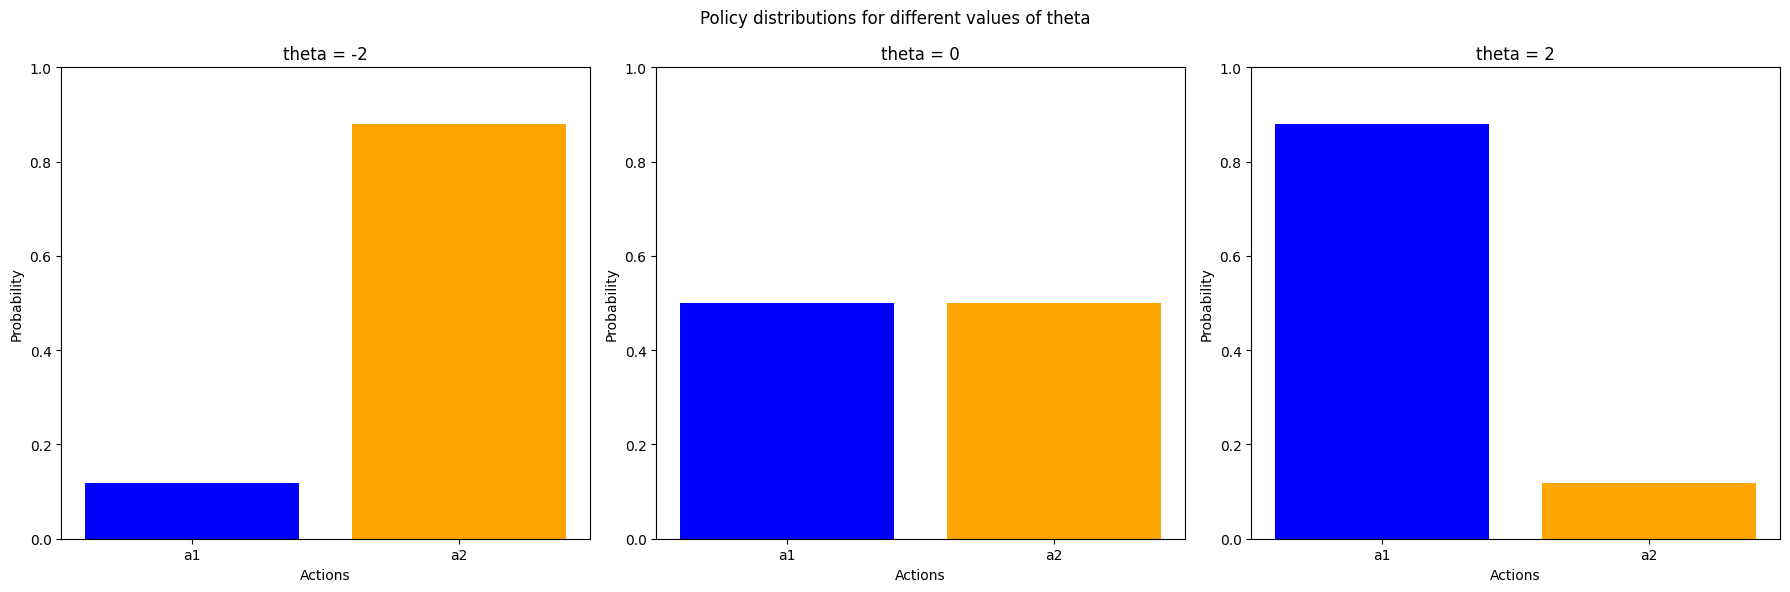

In [ ]:
# Define a range of theta values for demonstration
theta_values = [-2, 0, 2]

# Plot the policy distributions for each theta value
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, theta in enumerate(theta_values):
    # Calculate the probabilities for actions given the policy parameter theta
    prob_a1 = sigmoid(theta)  # Probability of taking action 1
    prob_a2 = 1 - sigmoid(theta)  # Probability of taking action 2

    # Plot the probability distribution for the current theta value
    axes[i].bar(['a1', 'a2'], [prob_a1, prob_a2], color=['blue', 'orange'])
    axes[i].set_title(f"theta = {theta}")
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Probability")
    axes[i].set_xlabel("Actions")

fig.suptitle('Policy distributions for different values of theta')
plt.tight_layout()
plt.show()


### KL-Divergence



As shown in the above image, we then want to limiting the difference when we do the optimization of parameter. An KL-divergence can be used to constraint that because it mesure how difference between two distributions are. The definition of KL in discret case: $$ D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)} $$



In [ ]:
# Calculate the policy distributions for the given theta values
theta_values_example = [-2, 0, 2]
policy_distributions_example = np.array([[sigmoid(theta), 1 - sigmoid(theta)] for theta in theta_values_example])

# Calculate the KL divergences between each pair of these distributions
kl_divergences = {}
for i, pdist1 in enumerate(policy_distributions_example):
    for j, pdist2 in enumerate(policy_distributions_example):
        if i < j:  # To avoid redundant calculation and self-comparison
            kl_div = entropy(pdist1, pdist2)
            kl_divergences[f"KL(Theta {theta_values_example[i]} || Theta {theta_values_example[j]})"] = kl_div

kl_divergences

{'KL(Theta -2 || Theta 0)': 0.32781332547273767,
 'KL(Theta -2 || Theta 2)': 1.5231883119115288,
 'KL(Theta 0 || Theta 2)': 0.43378083048302674}



###The objective function of Natural Policy Gradient: considering the KL-divergenve as an penalty term







We want to increase the most possible of the policy's parameters but we want to constraint the difference of the updated policy. We then have the objective function :
$$
d^* = \underset{d}{\text{arg max}} \, J(\theta + d) \quad \text{s.t.} \quad KL\left(\pi_{\theta}\parallel\pi_{\theta+d}\right) \leq \epsilon
$$
Convert it to an unconstrained penalized objective :
$$
d^* = \underset{d}{\text{arg max}} \, J(\theta + d) - \lambda \left( D_{KL}\left[\pi_{\theta} \parallel \pi_{\theta+d}\right] - \epsilon \right)
$$


###Taylor Expansion of objective and Fisher Information Matrix


The taylor expansion could be used to approximated the objective function:
$$
\approx \underset{d}{\text{arg max}} \, J(\theta_{\text{old}}) + \nabla_{\theta}J(\theta) |_{\theta=\theta_{\text{old}}} \cdot d - \frac{1}{2} \lambda d^T \nabla^2_{\theta} D_{KL}\left[\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}\right] |_{\theta=\theta_{\text{old}}} d + \lambda \epsilon
$$

The expansion of kl-divergence penalty term is :$$
D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) \approx D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta_{\text{old}}}) + d^T \nabla_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} + \frac{1}{2} d^T \nabla^2_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} d
$$

For the KL penalty term, the first order of expansion is 0, so the second order term is be used.$$\begin{align*}
\nabla_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} &= - \nabla_{\theta} \mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \log P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= - \mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \nabla_{\theta} \log P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= - \mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \frac{1}{P_{\theta_{\text{old}}}(x)} \nabla_{\theta} P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= \int_{x} P_{\theta_{\text{old}}}(x) \frac{1}{P_{\theta_{\text{old}}}(x)} \nabla_{\theta} P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= \int_{x} \nabla_{\theta} P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= \nabla_{\theta} \int_{x} P_{\theta}(x) |_{\theta=\theta_{\text{old}}} \\
&= 0
\end{align*}
$$
The seconde order can be derived to: $$
\begin{align*}
\nabla^2_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} &= -\mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \left[ \nabla^2_{\theta} \log P_{\theta}(x) \right] |_{\theta=\theta_{\text{old}}} \\
&= -\mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \left[ \nabla_{\theta} \left( \frac{\nabla_{\theta} P_{\theta}(x)}{P_{\theta}(x)} \right) \right] |_{\theta=\theta_{\text{old}}} \\
&= -\mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \left[ \frac{\nabla^2_{\theta} P_{\theta}(x) P_{\theta}(x) - \nabla_{\theta} P_{\theta}(x) \nabla_{\theta} P_{\theta}(x)^T}{P_{\theta}(x)^2} \right] |_{\theta=\theta_{\text{old}}} \\
&= \mathbb{E}_{x\sim\pi_{\theta_{\text{old}}}} \left[ \nabla_{\theta} \log P_{\theta}(x) \nabla_{\theta} \log P_{\theta}(x)^T \right] |_{\theta=\theta_{\text{old}}}\\&=F(\theta_{\text{old}})
\end{align*}
$$where F is exatly the same as Fisher Information Matrix.
So now, \begin{align*}
D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) &\approx D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta_{\text{old}}}) + d^T \nabla_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} + \frac{1}{2} d^T \nabla^2_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} d \\
&= \frac{1}{2} d^T F(\theta_{\text{old}}) d \\
&= \frac{1}{2} (\theta - \theta_{\text{old}})^T F(\theta_{\text{old}})(\theta - \theta_{\text{old}})
\end{align*}

The objective funtion can wirten as minorize problem $$
\begin{align*}
d^* &= \underset{d}{\text{arg max}} \, J(\theta + d) - \lambda(D_{KL}[\pi_{\theta} \parallel \pi_{\theta+d}] - \epsilon) \\
&\approx \underset{d}{\text{arg max}} \, J(\theta_{\text{old}}) + \nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}} \cdot d - \frac{1}{2} \lambda (d^T \nabla^2_{\theta} D_{KL}[\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}] |_{\theta=\theta_{\text{old}}} d) + \lambda \epsilon \\
&= \underset{d}{\text{arg max}} \, \nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}} \cdot d - \frac{1}{2} \lambda (d^T F(\theta_{\text{old}}) d) \\
&= \underset{d}{\text{arg min}} \, -\nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}} \cdot d + \frac{1}{2} \lambda (d^T F(\theta_{\text{old}}) d)
\end{align*}
$$

We can set the gradient to zero, $$\begin{align*}
0 &= \frac{\partial}{\partial d} \left( -\nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}} \cdot d + \frac{1}{2} \lambda (d^T F(\theta_{\text{old}})d) \right) \\
&= - \nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}} + \frac{1}{2} \lambda (F(\theta_{\text{old}})d)
\end{align*}
$$
so that the d which minimize the equation is $$
d = \frac{1}{\lambda} F^{-1}(\theta_{\text{old}}) \nabla_{\theta} J(\theta) |_{\theta=\theta_{\text{old}}}
$$ We have though the natual gradient $\begin{equation}
g_N =  F^{-1}(\theta_{\text{old}}) \nabla_{\theta} J(\theta) |_{\theta=\theta_{\text{old}}}
\end{equation}
$ Note that the $\frac{1}{\lambda}$ is an constant. We remplace the $g_N$ into the KL-divergence which is smaller than $\epsilon$: $$\begin{align*}
D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) &\approx \frac{1}{2}(\theta - \theta_{\text{old}})^T F(\theta_{\text{old}})(\theta - \theta_{\text{old}}) \\
&= \frac{1}{2}(\alpha g_N)^T F(\alpha g_N) = \epsilon
\end{align*}
$$Finally, the step size of the natural gradient is $$
\alpha = \sqrt{\frac{2\epsilon}{g_N^T F g_N}}
$$


## **Trust Region Policy Optimization (TRPO)**


### **Motivation: Problems with Natural policy optimization**


To understand the motivation behind the TRPO algorithm, let's first examine the limitations of Natural Policy Optimization (NPO). Although the natural gradient $ g_N =  F^{-1}(\theta_{\text{old}}) \nabla_{\theta} J(\theta) |_{\theta=\theta_{\text{old}}}$ provides a better direction for parameter update, several issues could be identified:
1. The KL divergence constraint may be violated. Since The step size $\alpha$ is computed using the second-order Taylor expansion approximation of the KL divergence:
$$\begin{align*}
D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) &\approx \frac{1}{2}(\theta - \theta_{\text{old}})^T F(\theta_{\text{old}})(\theta - \theta_{\text{old}}) \\
&= \frac{1}{2}(\alpha g_N)^T F(\alpha g_N) = \epsilon
\end{align*}$$
there is risk that our step size is too large, causing the KL divergence to exceed the threshold $ \epsilon $.
2. There is no guarantee that  $J(\theta + d) > J(\theta)$. To understand this, note that the objective established by NPO is
$$
d^* = \underset{d}{\text{arg max}} \, J(\theta + d) \quad \text{s.t.} \quad KL\left(\pi_{\theta}\parallel\pi_{\theta+d}\right) \leq \epsilon
$$. This allows us to find the best possible update d, but even the best update can not ensure policy improvement: the new policy $\pi_{\theta + d}$ could be worse than the original policy $\pi_{\theta}$.
3.The search direction is computed by approximately solving the equation $Ax=g$, where $A$ is the Fisher information matrix $F(\theta_{\text{old}})$, namely this equation:
$$
  \frac{1}{2} \lambda F(\theta_{\text{old}})  d = \nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}}
$$
where $F(\theta_{\text{old}}) =\nabla^2_{\theta} D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta}) |_{\theta=\theta_{\text{old}}} $. In large-scale problems, it is prohibitively costly (with respect to computation and memory) to form the full matrix $F\left(\mathrm{or}F^{-1}\right)$.
4. Only 1 step of parameter update could be done using rollout episodes generated by $\pi_{\theta_{\text{old}}}$. To accelerate training, it's crucial to use the rollout data more efficiently

### **What are the contributions of TRPO?**


In short, TRPO's contributions are in 4 folds:
1. The TRPO paper provides, by viewing the policy gradient processus as a classical policy iteration processus, a theoretical justification for our intuition in Natural Policy Optimization that we should introduce KL divergence constraint in addition to the original optimization objective $\underset{d}{\text{arg max}} \, J(\theta_{old} + d) $.
2. To resolve the first and second issue we mentioned above in the motivation part, i.e. (1) violation of KL constraint and (2) lack of guarantee of really improving the policy, TRPO employs a line search to determine the step size $\alpha$ such that both (1) make $J(\theta_{old} + \alpha \times  F^{-1}(\theta_{\text{old}})\nabla_{\theta}J(\theta) |_{\theta=\theta_{\text{old}}}) > J(\theta_{old})$ and (2) $D_{KL}(\pi_{\theta_{\text{old}}} \parallel \pi_{\theta_{old} + \alpha \times  F^{-1}(\theta_{\text{old}})\nabla_{\theta}J(\theta) |_{\theta=\theta_{\text{old}}}}) <$  the threshold we define.
3. TRPO utilizes the conjugate gradient algorithm allowing us to approximately solve the equation
$$
  \frac{1}{2} \lambda F(\theta_{\text{old}})  d = \nabla_{\theta}J(\theta)|_{\theta=\theta_{\text{old}}}
$$
without forming the full matrix $F$.
4. TRPO introduces importance sampling which allows for multiple steps of parameter updates to use rollout episodes of the previous policy, instead of just one-step parameter update per episode. (N.B. it is still considered as a on-policy algorithm.)

In the subsequent subsections, we provide detailed illustrations of these four aspects. Some sections include comprehensive mathematical derivations, which are essential for the technical understanding of TRPO methodology. Readers primarily interested in the overall framework may keep these subsections folded for a more smooth reading experience.

### **Before all**

Recall that in the previous section on NPO, we intuitively obtain the objective
$$
 \underset{d}{\text{arg max}} \, J(\theta_{old} + d) \quad \text{s.t.} \quad KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta_{old}+d}\right) \leq \epsilon
$$
Now if we think about what J is concretly, it turns out that J is exactly the policy gradient objective, that is, the expected reward approximated by sample reward average of rollout $\tau$ using $\pi_{\theta_{old}}$ ,i.e.
$$
J(\theta_{old} + d) = J(\theta) =\mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)] = \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\hat{A}_{\theta_{old}}(s_t^n,a_t^n)
$$
where $N$ is the number of episodes of rollout $\tau$ and t refers to timesteps of each episode. Now we can rewrite our objective as
$$
 \underset{\theta}{\text{max}} \, \mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)] ⇔ \underset{\theta}{\text{max}} \,\frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\hat{A}_{\theta_{old}}(s_t^n,a_t^n)  \quad \text{s.t.} \quad KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta}\right) \leq \epsilon.
$$

If we compare it with the objective function obtained through theoretical derivation in TRPO, given by:

$$
 \underset{\theta}{\text{max}} \,
 \mathbb{E}_{\tau\sim\pi_{\theta_{old}}}[\frac{p_{\pi_{\theta}}(\tau)}{p_{\pi_{\theta_{old}}}(\tau)}R(\tau)]
 ⇔
 \underset{\theta}{\text{max}} \, \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
  \quad \text{s.t.} \quad KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta}\right) \leq \epsilon.
$$

 we will find that the only difference between them is that TRPO introduces important sampling so that as if rollout $\tau$ is generated by $\pi_{\theta}$ (whatever which ) instead of by $\pi_{\theta_{old}}$

Let us first tackle the importance sampling part.

### **Importance Sampling**


Note that in the NPO objective function, we want to optimize $\mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)]$, however episodes $\tau$ are actually generated by the original policy $\pi_{\theta_{old}}$, so it may be innacurate to use $\mathbb{E}_{\tau\sim\pi_{\theta}}$. In policy Gradient, it is ok because every time we get episodes from a policy $\pi_{\theta_{old}}$, we only use them to perform one-step gradient ascent, in this case $\pi_{\theta_{old}}$ and $\pi_{\theta}$ is closed so it is tolerable think that $\tau$ is generated by $\pi_{\theta}$ although it is actually generated by $\pi_{\theta_{old}}$. However, if we would like to take advantage of the same rollout data to perfrom several furthur parameter updates, the difference between $\pi_{\theta_{old}}$ and $\pi_{\theta}$ could not be ignored and we would be forced to use $\mathbb{E}_{\tau\sim\pi_{\theta_{old}}}$. That is why importance sampling comes into play.
$$
\begin{align*}
 \mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)] &= ∫_{\tau} p_{\pi_{\theta}(\tau)}R(\tau) d\tau = ∫_{\tau} p_{\pi_{\theta_{old}}}(\tau) \frac{p_{\pi_{\theta}(\tau)}}{p_{\pi_{\theta_{old}}}(\tau)}R(\tau) d\tau \\
 &= \mathbb{E}_{\tau\sim\pi_{\theta_{old}}}[\frac{p_{\pi_{\theta}(\tau)}}{p_{\pi_{\theta_{old}}}(\tau)}R(\tau)]\\
  & = \mathbb{E}_{\tau\sim\pi_{\theta_{old}}}[ \frac{p(s_1)\prod_{t=1}^T \pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)}{p(s_1)\prod_{t=1}^T\pi_{\theta_{old}}(a_t|s_t)p(s_{t+1}|s_t,a_t)}R(\tau)]\\
  & = \mathbb{E}_{\tau\sim\pi_{\theta_{old}}}[ \frac{\prod_{t=1}^T \pi_\theta(a_t|s_t)}{\prod_{t=1}^T\pi_{\theta_{old}}(a_t|s_t)}R(\tau)]\\
  & = \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
\end{align*}
$$
The benifit of adopting importance sampling is in that we can leverage more efficiently data from rollouts. Specifically, as shown in the following image, a RL algorithm with importance sampling is capable of executing several parameter updates (for example, 5 times in our illustration) using the same rollout data from a previous policy. In large-scale problem, a rollout could be expensive and such property is valuable. On the other hand, an algorithm without importance sampling could only effectuate one parameter update per rollout.

![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215155102.png)

Now we present how TRPO paper derive the above objective by guidance of Policy iteration.

### **Theoretical justification for introducing KL divergence**

Recall that for Both NPO and TRPO, we want to optimize $J(\theta) = \mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)]$. Now let us depart from this and follow the  the derivation of TRPO paper to transform this simple objective function to  the final objective
$$
\underset{\theta}{\text{max}} \, \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
 \quad \text{s.t.} \quad KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta}\right) \leq \epsilon.
$$

First, denote $J(\theta) = \mathbb{E}_{\tau\sim\pi_{\theta}}[R(\tau)]$ as $\eta(\pi)$ .

TRPO tries to relate this expected discounted return miximizaiton problem to the classical policy iteration problem. Recall that in Policy iteration, we have 2 stages:
1. policy evaluation: evaluate the value function $V_{\pi_{\theta_{old}}}(S)$ after obtaining a policy $\pi_{\theta_{old}}$ from the previous policy improvement step.
2. policy improvement: find a new policy by letting for each state s, $\pi_{\theta}(s) = \underset{\pi_{\theta}}{\text{arg max}} \sum_{s^{\prime},r}p(s^{\prime},r|s,a)\big[r+\gamma V_{\pi_{\theta_{old}}}(s^{\prime})\big]$

We have theoretical guarantee that,  through the above defined policy improvement method, the new policy chosen is 100% not worse than the previous one.

#### Now, by analogy, What about thinking  of $\eta(\pi)$ also as a **value function of $\pi$**? This idea is not coming from nowhere. If we review REINFORCE algorithm from this perspective, we could also split it into 2 stages.

1. policy evaluation: **evaluate the value function $\eta(\pi_{old})$** by rollout data generated using a policy $\pi_{\theta_{old}}$ from the previous policy improvement step  (**in this case we do not have to explicitly evaluate it: just calculating advantage function $A(s,a)$ would provide sufficient information for the policy improvement stage**).  
2. policy improvement: obtain $\pi_{\theta}$ after gradient ascent using advantage function $A(s,a)$ aiming at maximizing $\eta(\pi_{old})$.

#### Now, by analogy again, in classical Policy iteration, the policy improvement can 100% find a better policy, Then in our "policy iteration" algorithm where $\eta(\pi)$ is value function, can we also find a policy improvement method that can promise us to have a better algorithm (rather than gradient ascent which cannot)? The answer by the TRPO paper is **YES**! They state the following policy improvement formula (which can guarantee that the true objective $\eta$ is non-decreasing):

$$
\mathbf{\pi_{\theta} = \underset{\pi_{\theta}}{\text{arg max}}} [L_{\pi_{old}}(\pi_{\theta})-CD_{\mathrm{KL}}^{\mathrm{max}}(\pi_{old},\pi_{\theta})]
$$

where
$$
\begin{align*}
 &D_\mathrm{KL}^\mathrm{max}(\pi,\tilde{\pi})=\operatorname*{max}_sD_{KL}(\pi(\cdot|s)\parallel\tilde{\pi}(\cdot|s))\\
 &{L}_{\pi_{old}}(\pi)=\eta(\pi_{old})+\sum_{s}\rho_{\pi_{old}}(s)\sum_{a}\pi(a|s)A_{\pi_{old}}(s,a)\\
 &C = \frac{4 \epsilon \gamma }{(1-\gamma)^{2}}\\
 & \epsilon = \operatorname*{max}_{s,a} |A_{\pi}(s,a)|\\
 & \text{and $\eta$ is the discounted rate.}
\end{align*}
$$

This trian of thought could be illustrated as:
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215155012.png)

This is called **Monotonic Improvement Guarantee** in TRPO paper. Here we will not bother to prove it, and we could safely ignore details such as what does $\rho$ mean and how we can come up with this for the sake of coherence. In the following part, we will see how we can get to the final objective by several approximations.

**Approximation1**  
now we know that by performing the following maximization, we are guaranteed to improve the true objective $\eta$:

$$
\underset{\theta}{\text{argmax}} \left[{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)-C{ D}_{\mathrm{KL}}^{\mathrm{max}}\left(\theta_{\mathrm{old}},\theta\right)\right].
$$
In practice, if we used the penalty coefficient C recommended by the theory above, the step sizes would be very small. One way to take larger steps in a robust way is to use a constraint on the KL divergence between the new policy
and the old policy, i.e., a **trust region constraint**:
$$
\underset{\theta}{\text{argmax}} [{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)] \quad s.t.\quad { D}_{\mathrm{KL}}^{\mathrm{max}}\left(\theta_{\mathrm{old}},\theta\right) < \delta
$$
So here we clearly see that the KL divergence constraint is introduced with theorectical justification. And also the name "**Trust Region** Policy Optimization".

**Approximation 2**

Since for a continuous State space,
$$
D_\mathrm{KL}^\mathrm{max}(\pi,\tilde{\pi})=\operatorname*{max}_sD_{KL}(\pi(\cdot|s)\parallel\tilde{\pi}(\cdot|s))
$$
is hard to calculate because we cannot iterate over a non-finite space, we turn to calculate the average KL divergence:
$$
\bar{D}_\mathrm{KL}(\theta_1 || \theta_2 ) = \mathbb{E}_{s \sim \rho}[D_{KL}(\pi(\cdot|s)\parallel\tilde{\pi}(\cdot|s))]
$$
Here, we do not care about the distrbution of s, because we will employ Monte Carlo Sampling (i.e. rollout) to take sample average. Now the objective becomes:

$$
\underset{\theta}{\text{argmax}} [{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)] \quad s.t.\quad  {\bar{D}_{\mathrm{KL}}}\left(\theta_{\mathrm{old}},\theta\right) < \delta
$$

Lastly it turns out that (details could be seen in the paper, just pure calculation)
$$
\underset{\theta}{\text{argmax}} [{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)]  \text{ is equivalent to }
$$
$$
\underset{\theta}{\text{argmax}} \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
$$

if we introduce importance sampling. Now we get the afore-mentioned TRPO objective function:
$$
\underset{\theta}{\text{max}} \, \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
 \quad \text{s.t.} \quad KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta}\right) \leq \delta.
$$

Until now, we have explored the evolution of TRPO from its origins in policy iteration algorithms, detailing its step-by-step introduction of the KL divergence constraint and showing that the same objective function with Natural Policy Optimization is finally obtained. Although several approximations are made so that the theoretical guarantee are not anymore strictly valid, parctical experiments show that it works robustly.

### **Line search**

Now we have shown that TRPO and NPO share the same objective function, it is natural that TRPO would use the NPO parameter updates direction
 $$
g_k =  F^{-1}(\theta_{\text{old}}) \nabla_{\theta} J(\theta) |_{\theta=\theta_{\text{old}}}
$$
as well as the step size
$$
\alpha = \sqrt{\frac{2\delta}{g_k^T F g_k}}
$$
However, in addition, TRPO applies a line search to really ensure improvement of $L_{\theta_{old}}(\theta)$ and satisfaction of the KL divergence constraint. This is reasonable because we indeed did so much approximation that KL divergence constraint is not satisfied. Moreover, from the theoretical derivation of the preivous section, we know that if we can improve $L_{\theta_{old}}(\theta)$, we have the "monotonic improvement guarantee" to also improve $\eta$, so the second goal of the line search is to improve $L$. More concretely, here is the pseudo code of the line search:
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215175749.png)

In the image, $\alpha \in (0,1) $ is a decay rate that exponentially vanishes to 0 with j. We can also illustrate it as
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215182023.png)
we may see that by shrinking the original step size determined by NPO, we could avoid from violating constraint.




### **Conjugate Gradient**


This is one of the main differences from the NPO algorithm. When performing gradient ascent in NPO, it is necessary to compute the inverse of the Fisher information matrix $F(θ)$, denoted as $F(θ)^{-1}$. This requires a very high computational resource. If the policy's parameter has a dimension n = 100, the matrix F contains 10,000 elements. Computing the inverse matrix $F(θ)^{-1}$ using the common method of Gaussian elimination requires $O(n^3)$ steps. As an improvement for simplicity, the conjugate gradient method is used, which only requires less than n steps(O(n) complexity). This means that the conjugate gradient scales linearly with the parameters, whereas in NPO, it scales cubically.
In conjugate gradient, we do not need to compute $F^{-1}$, but can directly solve $$x = F^{-1}g$$
Solving $Fx = g$ is equivalent to minimizing $$f(x) = \frac{1}{2}x^TFx - g^Tx$$ since $f'(x) = Fx - g = 0$.
By using the Conjugate Gradient method to minimize $f(x)$, we can solve $Fx = g$ without computing the matrix inverse, which is computationally more efficient ($O(n)$).

The pseudo code of CG:
1. **Initialization**:
   - Choose an initial guess $x_0$, usually the zero vector.
   - Compute the residual $r_0 = g - Fx_0$.
   - Set the search direction $p_0 = r_0$.

2. **Iteration**:
   For each iteration $k$:
   - Compute the step size $\alpha_k = \frac{r_k^Tr_k}{p_k^TFp_k}$.
   - Update the solution $x_{k+1} = x_k + \alpha_k p_k$.
   - Compute the new residual $r_{k+1} = r_k - \alpha_k Fp_k$.
   - If $r_{k+1}$ is sufficiently small, then stop.
   - Compute the coefficient for the next search direction $\beta_k = \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$.
   - Update the search direction $p_{k+1} = r_{k+1} + \beta_k p_k$.

3. **Termination**:
   - The algorithm stops when the residual $r_k$ is sufficiently small, or the maximum number of iterations has been reached.



## **Proximal Policy Optimization (PPO)**

Now we comes finally to PPO. The idea of PPO is to be able to scalle up TRPO. As we mentioned before, TRPO uses second-order optimization techniques and that requires calculating Hessian Matrix. In contrast, PPO uses first-order optimization, i.e. SGD, so it is less computation-consuming.

To be able to use first-order optimization while ensuring KL divergence, the paper proposed 2 alternatives:

1. Adaptive KL Penalty Coefficient. The idea is, recall that the reason why we introduce the KL divergence in a constraint form is that in the original objective
$$
\underset{\theta}{\text{argmax}} \left[{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)-C{ D}_{\mathrm{KL}}^{\mathrm{max}}\left(\theta_{\mathrm{old}},\theta\right)\right].
$$
the value of C is problematique. Now PPO proposes that apart from the solution of TRPO, there exist another solution to this: make C adaptable. So in the end, the objective of PPO is
$$
\underset{\theta}{\text{max}} \, \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n)
  - \mathbb{\beta} \times KL\left(\pi_{\theta_{old}}\parallel\pi_{\theta}\right).
$$
where $\beta$ takes the place of $C$ in TRPO. The concret way we adjust the $\beta$ is:
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215193512.png)
Namely, we will first set a target KL-divergence value $d_{targ}$. Then after the parameter updating, if we found that the real KL-divergence is too large, then we augment $\beta$ to augment penalty. Otherwise, if d is too small, we shrink $\beta$. Then the updated β is used for the next policy update
2. Clipped Surrogate Objective. The idea is, to avoid policy change, instead of introducing KL divergence which augments significantly the computation complexity, we may investigate more straight-away methods. For example, the original TRPO objective without KL is

$$
 [{ L}_{\theta_{\mathrm{old}}}\left(\theta\right)]  \text{ which is equivalent to }
$$

$$
 \frac{1}{N}\sum_{n=1}^N\prod_{t=1}^t\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}\hat{A}(s_t^n,a_t^n) := \hat{\mathrm{E}}_{t}\Bigl[r_{t}(\theta)\hat{A}_{t}\Bigr]
$$

now consider
$$
L^{C L I P}(\theta)=\mathrm{\hat{E}}_{t}\Bigl[\mathrm{min}(r_{t}(\theta)\hat{A}_{t},\mathrm{clip}(r_{t}(\theta),1-\epsilon,1+\epsilon)\hat{A}_{t})\Bigr]
$$
Where epsilon is defined by us, for example, 0.2. This modification enables the algorithm to penalize changes to the policy that
move $r_t(\theta)$ away from 1. Too see this, let us first consider the function clip.
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215200539.png)
Now if we superpose the function min, it will becomes:
![](https://raw.githubusercontent.com/YuchenHui22314/picgo/main/img/20231215195841.png)
First, we should realize the meaning of "clip". if $\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}$ is clipped, then there will be no gradient signal for this A on the $\theta$.Here, we see that, when $A > 0$, which means, if the gradient is not 0, then this positive A will still make $\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}$ larger, in this case if it has already > threshold $1 + \epsilon$, we will not allow A to make it larger by stoping the gradient of A. On the other hand if the ratio is less than the threshold, we will not stop A's gradient because we think the difference between original policy and current policy is still tolerable, we can still augment it.

When $A < 0$ we will stop A's gradient when $\frac{\pi_\theta(a_t^n|s_t^n)}{\pi_{\theta_{old}}(a_t^n|s_t^n)}$ is less than threshold because otherwise this negative A's gradient will make the ratio even smaller. However when the ratio is still around 1, we do nothing and let the gradient of A (a negetive number) pass by to reduce the ratio.

In summury, it turns out that by dynamically stopping gradient when policy becomes more different that we admit, we can achieve the same effect as constraint KL divergence.